In [1]:
# Imports and global constants
import math
import scipy
import numpy as np
from src import fossil_utils
import geodatasets
import pandas as pd
import shapely.geometry
import geopandas as gpd
import matplotlib as mpl
import statsmodels.api as sm
import matplotlib.pyplot as plt

from typing import Tuple
from src.constants import *
from matplotlib import cm

# Detecting patterns of speciation in the fossil record

### Required packages
To run this code, you need at least Python 3.7 and the following packages:
```
pip install numpy pandas matplotlib shapely geopandas rtree pygeos scipy statsmodels
```
If you have issues with GeoPandas, you might need to manually install GEOS libraries. Check https://geopandas.org/install.html for more info.

#### Helper files
This Jupiter Notebook imports two helper scripts (`fossil_utils.py` and `constants.py`), containing utility functions and constants used throughout the exercises. In addition, in `./now_db.csv` there is a copy of the NOW database downloaded in date 04/05/2022 (May 4th).

## 1. Load and Cleaning Data

In [2]:
# (Exercise 2) Reads database from file as Pandas DataFrame.
db = pd.read_csv(ORIGINAL_DB_PATH, sep=SEPARATOR)
print("Original DB data rows:", len(db))
db

Original DB data rows: 70274


LIDNUM       NAME      LATSTR      LONGSTR        LAT        LONG  \
0       21390      Aarau   47 23 0 N      8 3 0 E  47.383000    8.050000   
1       29029  Aarwangen  47 14 37 N    7 45 21 E  47.243654    7.755959   
2       27232  Aba Zawei  33 15 00 N  102 25 00 E  33.250000  102.416667   
3       27232  Aba Zawei  33 15 00 N  102 25 00 E  33.250000  102.416667   
4       27232  Aba Zawei  33 15 00 N  102 25 00 E  33.250000  102.416667   
...       ...        ...         ...          ...        ...         ...   
70269   24624   Zuurland  51 50 00 N   04 10 00 E  51.833333    4.166667   
70270   24624   Zuurland  51 50 00 N   04 10 00 E  51.833333    4.166667   
70271   24624   Zuurland  51 50 00 N   04 10 00 E  51.833333    4.166667   
70272   24624   Zuurland  51 50 00 N   04 10 00 E  51.833333    4.166667   
70273   24624   Zuurland  51 50 00 N   04 10 00 E  51.833333    4.166667   

       MAX_AGE BFA_MAX BFA_MAX_ABS FRAC_MAX  ...  MW_CS_BLUNT DIET_1  \
0      14.2000     mn6          \N       \N  ...           \N     \N   
1      25.4100    mp27          \N       \N  ...           \N     \N   
2       0.0295      \N         C14       \N  ...           \N      p   
3       0.0295      \N         C14       \N  ...           \N      p   
4       0.0295      \N         C14       \N  ...           \N      p   
...        ...     ...         ...      ...  ...          ...    ...   
70269   2.5000    mn17          \N       \N  ...           \N      a   
70270   2.5000    mn17          \N       \N  ...           \N      a   
70271   2.5000    mn17          \N       \N  ...           \N      a   
70272   2.5000    mn17          \N       \N  ...           \N      a   
70273   2.5000    mn17          \N       \N  ...          NaN    NaN   

          DIET_2 DIET_3 LOCOMO1    LOCOMO2    LOCOMO3 SPCOMMENT  \
0             \N     \N      \N         \N         \N        \N   
1             \N     \N      \N         \N         \N        \N   
2      herbivore  graze      te  surficial  cursorial        \N   
3      herbivore  graze      te  surficial   gen_quad        \N   
4      herbivore     \N      te         \N         \N        \N   
...          ...    ...     ...        ...        ...       ...   
70269         \N     \N      \N         \N         \N        \N   
70270         \N     \N      \N         \N         \N        \N   
70271         \N     \N      \N         \N         \N        \N   
70272         \N     \N      \N         \N         \N        \N   
70273        NaN    NaN     NaN        NaN        NaN       NaN   

                   SP_SYNONYM SP_SYNONYM_COMMENT  
0                          \N                 \N  
1                          \N                 \N  
2                          \N                 \N  
3      Rhinoceros tichorhinus                 \N  
4                          \N                 \N  
...                       ...                ...  
70269                      \N                 \N  
70270                      \N                 \N  
70271                      \N                 \N  
70272                      \N                 \N  
70273                     NaN                NaN  

[70274 rows x 88 columns]

In [3]:
# Drops invalid entries from DB:
#    - latitude and longitude == 0
#    - Species either "sp." or "indet."
def drop_invalid_data(data: pd.DataFrame) -> pd.DataFrame:
    invalid_coord_data = (data["LAT"] == 0) | (data["LONG"] == 0)
    unknown_species_data = (data["SPECIES"] == "sp.") | (data["SPECIES"] == "indet.")
    indexes_to_drop = data[invalid_coord_data | unknown_species_data].index
    return data.drop(index=indexes_to_drop)

db_clean = drop_invalid_data(db)

In [4]:
# Assign each record to its Mammalian Neogene time unit (TIME_UNIT), according to the average of max and min age
def assign_time_units(df: pd.DataFrame) -> pd.Series:
    """Assign a Mammalian Neogene (MN) **time unit index** to each record.

    Uses fossil_utils.get_sorted_tu() and maps by the mean of MIN_AGE and MAX_AGE.
    The utility provides the boundaries and indexes for each MN time unit.

    Returns
    -------
    pd.Series (int)
        The MN time unit index for each row.
    """
    sorted_tu = fossil_utils.get_sorted_tu()

    def pick_tu(mean_age: float) -> int:
        for tu in sorted_tu:
            if mean_age >= tu.min:
                return tu.index
        # Fallback to the oldest if nothing matched (should not happen for valid ages)
        return sorted_tu[-1].index

    mean_age = df[["MIN_AGE", "MAX_AGE"]].mean(axis=1)
    return mean_age.apply(pick_tu)

db_clean[TIME_UNIT] = assign_time_units(db_clean)

In [5]:
# Reassign TU labels based on location, according to some experts' opinion
db_clean.loc[db_clean["NAME"] == "Samos Main Bone Beds", TIME_UNIT] = fossil_utils.tu_name_to_index("MN12")
db_clean.loc[db_clean["NAME"] == "Can Llobateres 1", TIME_UNIT] = fossil_utils.tu_name_to_index("MN9")

In [6]:
# For each entry in the database, assign a numeric SPECIMEN_ID uniquely made by the combination of
# GENUS and SPECIES values.
db_clean[SPECIMEN_ID] = db_clean.groupby(["GENUS","SPECIES"]).ngroup()

In [7]:
# Remove duplicate SPECIMEN_ID that are in the same location
db_clean.drop_duplicates(subset=[SPECIMEN_ID, "NAME"], inplace=True)

In [8]:
# Prints some information about the datasets
def print_info():
    original_db_entries_count = len(db)
    cleaned_db_entries_count = len(db_clean)
    print(f"Data rows after cleaning: {cleaned_db_entries_count} (removed: {original_db_entries_count - cleaned_db_entries_count})")
    print("Unique Specimens:", db_clean[SPECIMEN_ID].unique().size)
    print("Unique Localities:", db_clean["NAME"].unique().size)

print_info()

Data rows after cleaning: 51398 (removed: 18876)
Unique Specimens: 10306
Unique Localities: 5780


## 2. Summaries by time unit
We compute *total* and *first* occurrences by MN time unit, and their ratio.

In [9]:
def summarize_by_time(data: pd.DataFrame):
    tu_indexes = fossil_utils.get_tu_indexes()

    # Create a view of the data for easier handling
    subset_data = data[[SPECIMEN_ID, TIME_UNIT]]

    # Calculate occurrences_per_tu
    tu_columns = [
        subset_data[subset_data[TIME_UNIT] == tu_index]
            .groupby(SPECIMEN_ID, as_index=True)
            .count()
        for tu_index in tu_indexes
    ]

    occurrences_per_tu = pd.concat(tu_columns, axis=1, sort=True).fillna(0).astype(int)
    occurrences_per_tu.columns = tu_indexes

    def find_first_occurrence(x: pd.Series) -> pd.Series:
        first_not_null = x.dropna().index[0]
        x[first_not_null:] = np.nan
        return x.astype(float)

    # For each SPECIES_ID, keep only the first occurrences from the previous table
    tu_first_occurrences = occurrences_per_tu.replace(0, np.nan).apply(find_first_occurrence, axis=1)

    # For counting first UNIQUE SPECIES
    tu_first_occurrence_count = (~tu_first_occurrences.isnull()).sum(axis=0)

    # For counting first TOTAL SPECIES
    #tu_first_occurrence_count = tu_first_occurrences.sum(axis=0)

    tu_total_occurrences_count = occurrences_per_tu.sum(axis=0).sort_index()
    occurrence_ratios = tu_first_occurrence_count / tu_total_occurrences_count

    return tu_total_occurrences_count, occurrence_ratios

total_occurrences, occurrence_ratio = summarize_by_time(db_clean)

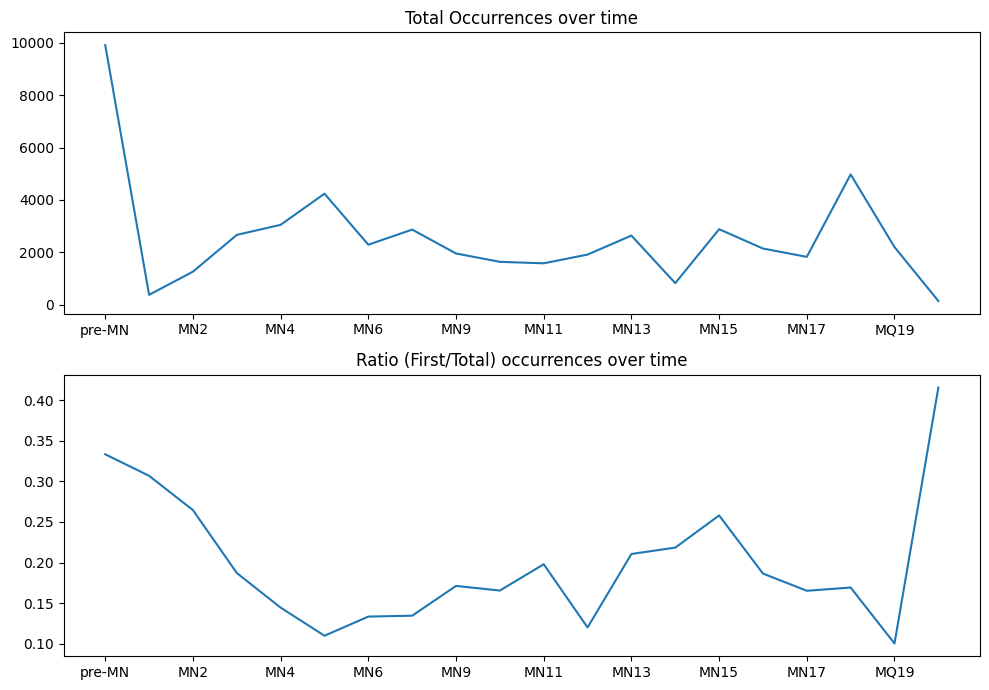

In [10]:
#Plots data of specimen occurrences in time periods
def plot_time_period_occurrences(_total_occurrences: pd.Series, _occurrence_ratio: pd.Series):

    fig, (ax_total, ax_ratio) = plt.subplots(nrows=2, ncols=1, figsize=(10, 7))
    ticks = fossil_utils.get_tu_indexes()[0::2]
    labels = list(map(fossil_utils.tu_index_to_name, ticks))

    ax_total.set_title("Total Occurrences over time")
    ax_total.plot(_total_occurrences)
    ax_total.set_xticks(ticks=ticks, labels=labels)

    ax_ratio.set_title("Ratio (First/Total) occurrences over time")
    ax_ratio.plot(_occurrence_ratio)
    ax_ratio.set_xticks(ticks=ticks, labels=labels)
    
    fig.tight_layout()
    
plot_time_period_occurrences(total_occurrences, occurrence_ratio)

### Geometry and per‑locality counts
Let's now aggregate data for each locality. Each locality is uniquely identified with an integer LIDNUM and a string NAME. For all the grouping and merging operations I will use the LIDNUM id instead of the NAME field, because integer fields are more performant than strings to compare and handle.

In [11]:
def ex_5a(data: pd.DataFrame) -> Tuple[gpd.GeoDataFrame, pd.DataFrame]:
    # Create a subset of the data to work with
    subset_data = data[[LIDNUM, "LONG", "LAT", SPECIMEN_ID, TIME_UNIT]]

    # Group by locations
    location_groups = subset_data.groupby(LIDNUM)

    # Construct map {specimen_id: TU_id of first occurrence}
    species_to_tu_of_first_appearance = subset_data.groupby(SPECIMEN_ID, as_index=False)[TIME_UNIT].min()

    # Construct map {TU_id: set(specimen ids occurred for the first time)}
    tu_to_species_of_first_appearance = species_to_tu_of_first_appearance.groupby(TIME_UNIT)[SPECIMEN_ID].apply(set)

    # reduce the groups to one line each, selecting long, lat and TU
    unique_locations = location_groups[["LONG", "LAT", TIME_UNIT]].min()

    # For each location, get the set of specimens found in that location
    all_unique_occurrences_in_localities = location_groups[SPECIMEN_ID].apply(set)

    # Aggregate data calculated so far in a DataFrame
    all_location_data = pd.concat([unique_locations, all_unique_occurrences_in_localities], axis=1, verify_integrity=True)
    all_location_data.rename(columns={SPECIMEN_ID: ALL_OCCURRENCES}, inplace=True)

    # For every location, find which of its specimens make a first appearance in its TIME_UNIT
    set_appearances_per_tu = tu_to_species_of_first_appearance[all_location_data[TIME_UNIT]].to_numpy()
    set_first_specimens_per_location = all_location_data[ALL_OCCURRENCES].to_numpy()
    all_location_data[FIRST_OCCURRENCES] = set_appearances_per_tu & set_first_specimens_per_location

    # Now count the number of entries in the FIRST_OCCURRENCES and ALL_OCCURRENCES
    occurrences_count = all_location_data[[ALL_OCCURRENCES, FIRST_OCCURRENCES]].map(len)
    all_location_data.loc[:, [ALL_OCCURRENCES, FIRST_OCCURRENCES]] = occurrences_count

    # Calculate ratio
    all_location_data["OCCURRENCES_RATIO"] = all_location_data[FIRST_OCCURRENCES] / all_location_data[ALL_OCCURRENCES]

    # Return data needed for next steps ()
    return fossil_utils.to_GeoDataFrame(all_location_data), species_to_tu_of_first_appearance

# NOTE: species_to_tu_of_first_appearance is reused later
localities_geodata, species_to_tu_of_first_appearance = ex_5a(db_clean)

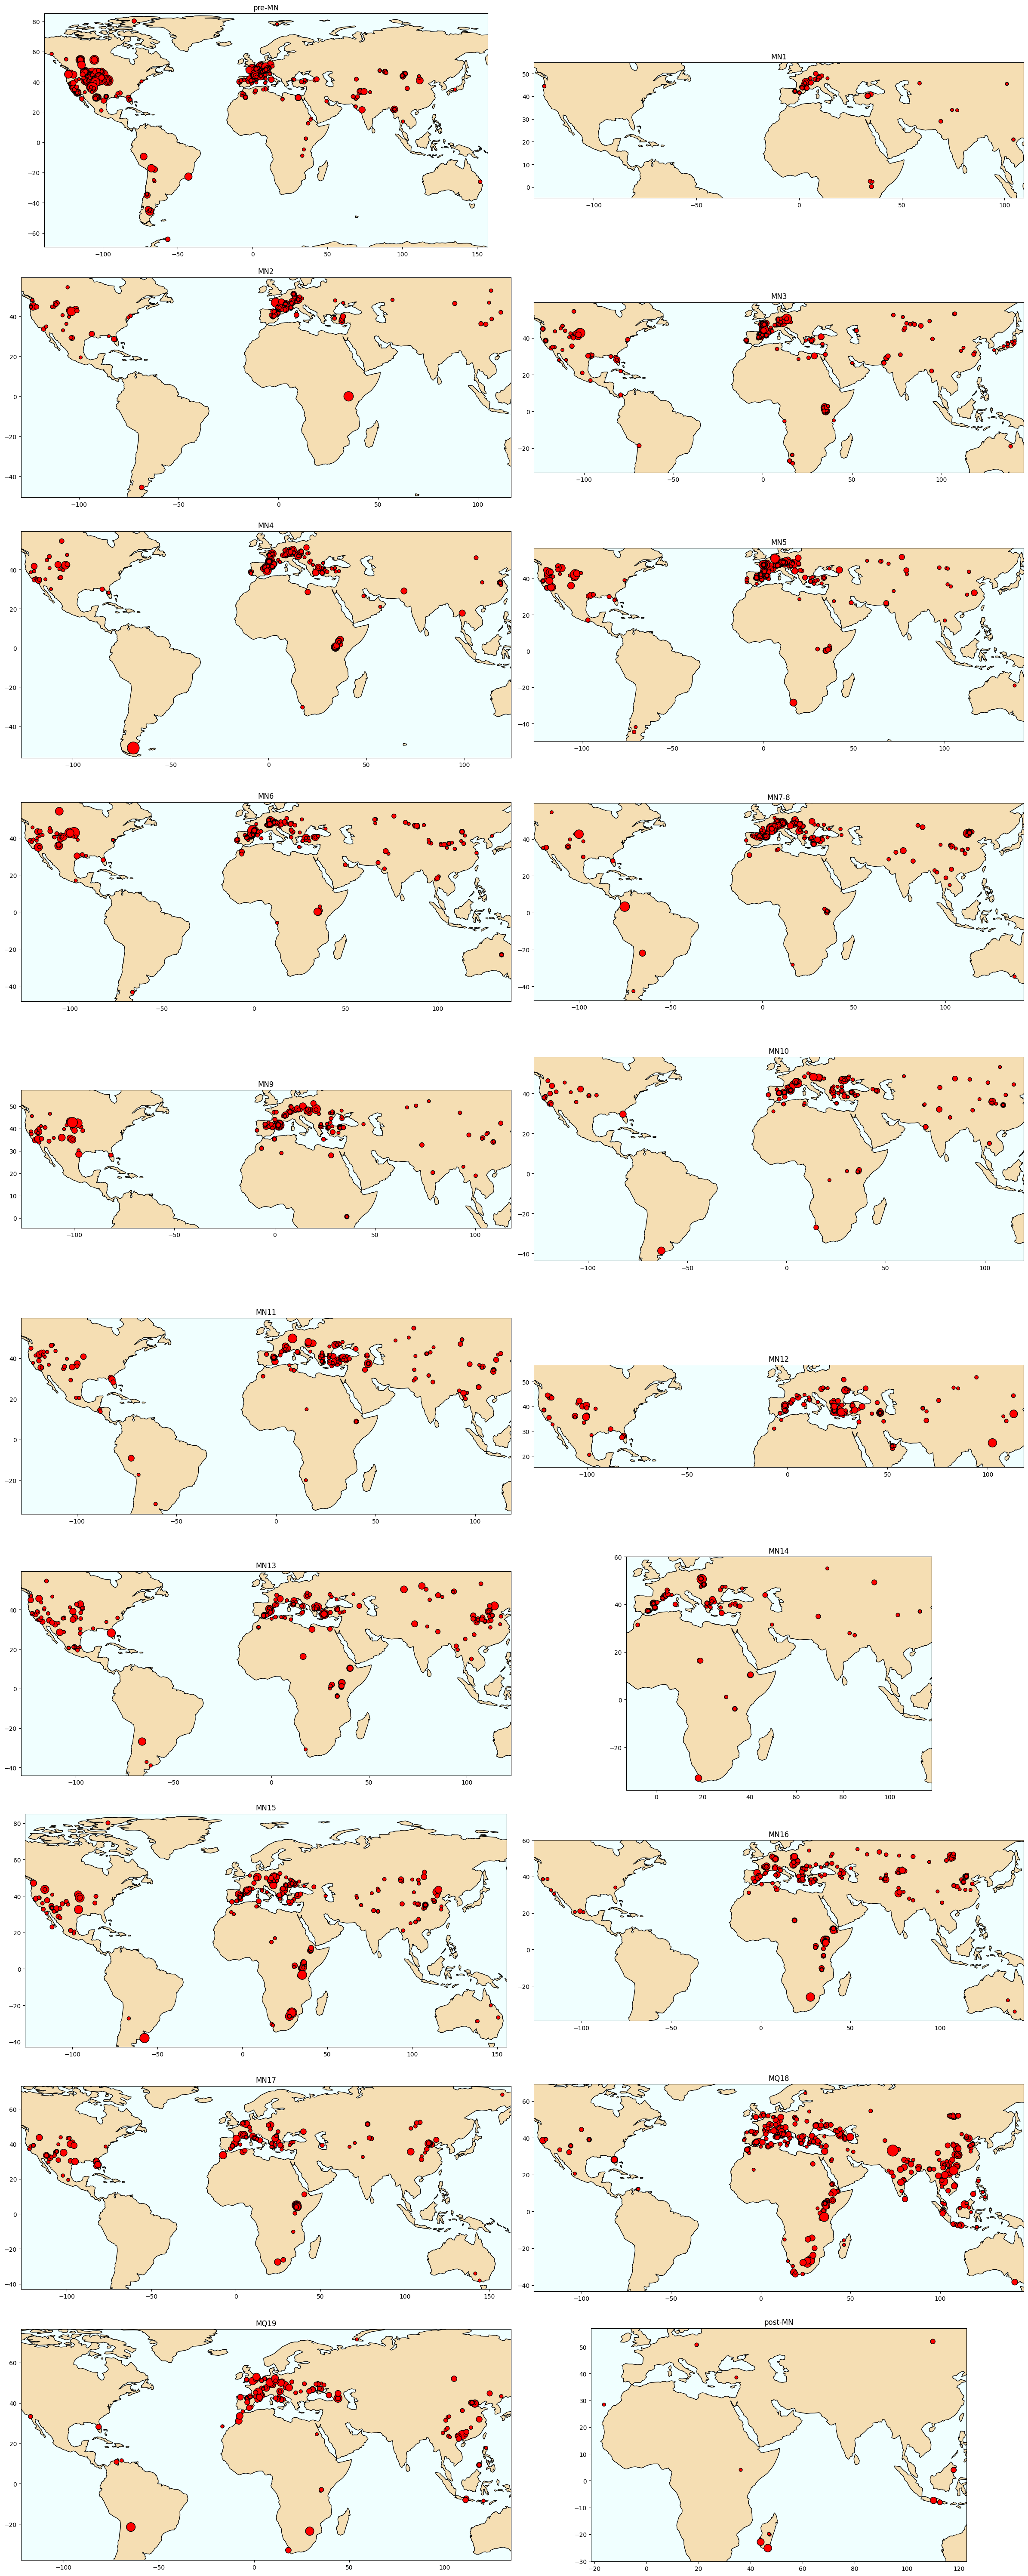

In [12]:
# Import world map
world_map = gpd.read_file(geodatasets.get_path("naturalearth.land"))

def plot_data_on_map(geo_data: gpd.GeoDataFrame):
    groups = geo_data.groupby(TIME_UNIT)

    # Create subplots and change ax to 1d Array
    n_cols = 2
    n_rows = math.ceil(len(groups) / n_cols)
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(12 * n_cols, 6 * n_rows))
    ax = ax.reshape((ax.size,))

    # interpolates the values of all occurrences to determine marker sizes
    size_interpolator = fossil_utils.Interpolator(30, 500, geo_data[ALL_OCCURRENCES].min(), geo_data[ALL_OCCURRENCES].max())

    i = 0
    margin = 5
    for tu_index, group in groups:
        # Delimit the world view to only the area containing occurrences
        ax[i].set_ylim((group["LAT"].min() - margin, group["LAT"].max() + margin))
        ax[i].set_xlim((group["LONG"].min() - margin, group["LONG"].max() + margin))
        ax[i].set_title(fossil_utils.tu_index_to_name(tu_index))

        # Print world map
        ax[i].set_facecolor("azure")
        world_map.plot(ax=ax[i], color="wheat", edgecolor="black")

        # Calculates the size for each point in the group
        sizes = group[ALL_OCCURRENCES].map(size_interpolator.interpolate)
        
        # Print a dot for each occurrence
        group.plot(ax=ax[i], color="red", edgecolor="black", markersize=sizes)

        # Advences chart
        i += 1

    plt.tight_layout()
    plt.show()

plot_data_on_map(localities_geodata)

To have a better understanding of the distribution at the global scale, let's also print all the occurrences together in the same map. The Time Unit age is color-coded according to the legend, and the marker size is proportional to the number of occurrences per locality (like in the previous maps)

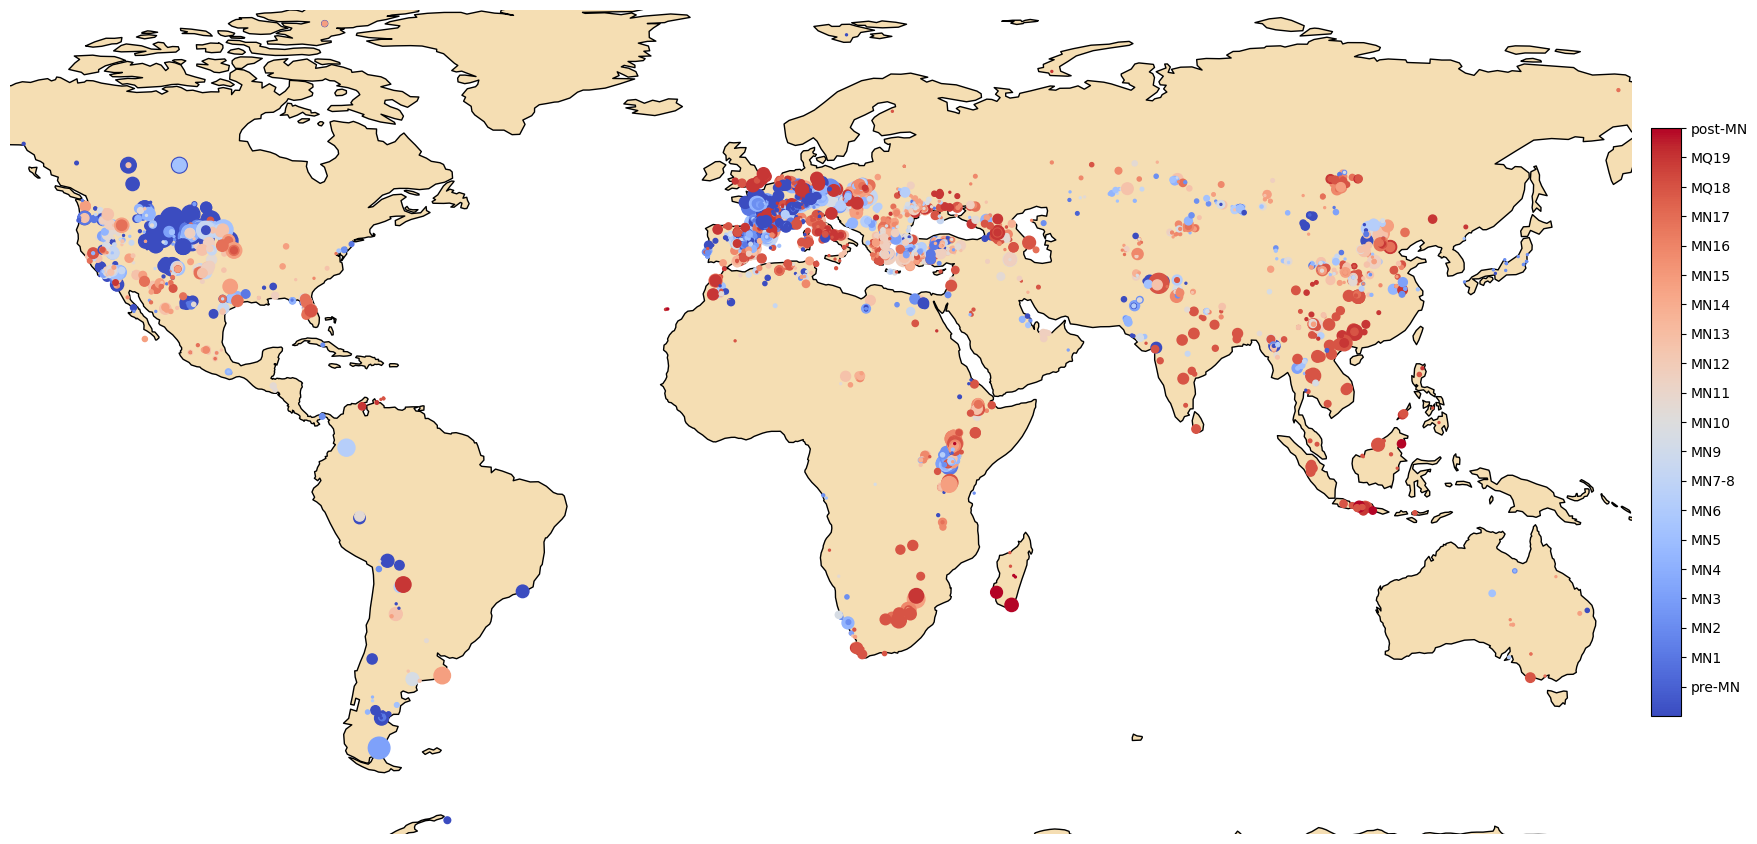

In [13]:
def plot_combined_occurrences(geo_data: gpd.GeoDataFrame):
    tu_indexes = fossil_utils.get_tu_indexes()

    # Create an Axes that will contain all the plots
    fig, ax = plt.subplots(figsize=(20, 15))

    # Print world map on ax
    margin = 2.5
    ax.set_facecolor("azure")
    world_map.plot(ax=ax, color="wheat", edgecolor="black")
    ax.set_ylim((geo_data["LAT"].min() - margin, geo_data["LAT"].max() + margin))
    ax.set_xlim((geo_data["LONG"].min() - margin, geo_data["LONG"].max() + margin))

    # interpolates the values of all occurrences to determine marker sizes
    size_interpolator = fossil_utils.Interpolator(2, 300, geo_data[ALL_OCCURRENCES].min(), geo_data[ALL_OCCURRENCES].max())
    sizes = geo_data[ALL_OCCURRENCES].map(size_interpolator.interpolate)

    # Plot the coordinates in geo_data, specifying the size and a color map based on TIME_UNIT
    cmap = plt.colormaps['coolwarm']
    geo_data.plot(ax=ax, column=TIME_UNIT, cmap=cmap, markersize=sizes)

    # Set Legend style
    legend = fig.colorbar(cm.ScalarMappable(cmap=cmap), ax=ax, shrink=0.4, orientation='vertical', pad=0.01)
    ticks = np.divide(tu_indexes, len(tu_indexes))
    legend.set_ticks(ticks=ticks, labels=fossil_utils.get_tu_names())

    plt.tight_layout()
    plt.axis("off")
    plt.show()  

plot_combined_occurrences(localities_geodata)

In [14]:
def print_occurrences_per_continent(localities_data: gpd.GeoDataFrame):
    # Load the deprecated world map. The new one doesn't have continents
    world = gpd.read_file(COUNTRY_DATA_PATH, layer="ne_110m_admin_0_countries")

    for continent in ["Europe", "Asia", "Africa", "North America", "South America", "Oceania"]:
        continent_geometry = world[world["CONTINENT"] == continent]

        # Perform a spatial join
        data_in_continent = gpd.sjoin(localities_data, continent_geometry)
        print(f"* {continent} \n\t- Total occurrences: {data_in_continent[ALL_OCCURRENCES].sum()}. \n\t- Average occurrences per locality: {data_in_continent[ALL_OCCURRENCES].mean()}")

print_occurrences_per_continent(localities_geodata)

* Europe 
	- Total occurrences: 23329. 
	- Average occurrences per locality: 8.364646826819648
* Asia 
	- Total occurrences: 8053. 
	- Average occurrences per locality: 6.91244635193133
* Africa 
	- Total occurrences: 5994. 
	- Average occurrences per locality: 9.858552631578947
* North America 
	- Total occurrences: 12462. 
	- Average occurrences per locality: 12.08729388942774
* South America 
	- Total occurrences: 604. 
	- Average occurrences per locality: 18.303030303030305
* Oceania 
	- Total occurrences: 33. 
	- Average occurrences per locality: 2.357142857142857


### Observations on Record sampling
From the map computed previously, we can observe that the occurrences are not evenly distributed in time and space. For example, in Africa there is a prevalence of occurrences in more recent time units, while in North America there is a prevalence of occurrences from older time units.
Also, Europe has a much larger number of occurrences compared to other continents, followed by North America. Parts of Asia, Africa and South America are completely lacking data from several time units.

## 1.4 - Localities and Sampling

In [15]:
def update_localities_witharea_info(localities_geodata: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    def to_box(point):
        return shapely.geometry.box(
            minx=point.x - AREA_HALF_EDGE,
            miny=point.y - AREA_HALF_EDGE,
            maxx=point.x + AREA_HALF_EDGE,
            maxy=point.y + AREA_HALF_EDGE,
        )

    # Prepare the "right-side" GeoDataFrame for spatial join. Replace all point-like coordinates with a squared area
    # centered at the locality
    area_data_right = localities_geodata.loc[:, [TIME_UNIT, ALL_OCCURRENCES, FIRST_OCCURRENCES, "geometry"]]
    area_data_right["geometry"] = localities_geodata["geometry"].apply(to_box)

    # Prepare the "left-side" GeoDataFrame for spatial join. Select only necessary columns for performing further
    # grouping and filtering after the join.
    localities_data_left = localities_geodata[[TIME_UNIT, "geometry"]]

    # Do a spatial join where all points on the left side are matched to all the areas on the right side.
    # All the (left) points within the (right) areas will be joined, in a relation (Many --> Many)
    joint_data = gpd.sjoin(localities_data_left, area_data_right, how="left", predicate="within")

    tu_left = TIME_UNIT + "_left"
    tu_right = TIME_UNIT + "_right"

    # Select localities in the same area having same TIME_UNIT
    occurrences_same_tu = joint_data[joint_data[tu_left] == joint_data[tu_right]]

    # Select localities in the same area having TIME_UNIT of one unit older than the focal locality
    # Note the order of the equality!
    #   - joint_data[tu_right]: areas around focal locality,
    #   - joint_data[tu_left]:  focal locality)
    occurrences_previous_tu = joint_data[joint_data[tu_right] == joint_data[tu_left] - 1]

    # Aggregate occurrences' data by index (LIDNUM)
    area_occurrences_same_tu = occurrences_same_tu.groupby(occurrences_same_tu.index).agg({ALL_OCCURRENCES: "sum", FIRST_OCCURRENCES: "sum"})
    area_occurrences_previous_tu = occurrences_previous_tu.groupby(occurrences_previous_tu.index).agg({ALL_OCCURRENCES: "sum"})

    # extend original dataset with new data
    area_data = pd.DataFrame({
        "AREA_FIRST_OCC": area_occurrences_same_tu[FIRST_OCCURRENCES],
        "AREA_TOTAL_OCC": area_occurrences_same_tu[ALL_OCCURRENCES],
        "AREA_TOTAL_OCC_PREV_TU": area_occurrences_previous_tu[ALL_OCCURRENCES]
    }).astype(float).fillna(value=0.0).astype(int)

    # This returns a GeoDataFrame as long as a GeoDataFrame is on the left side of the join
    localities_area_geodata = pd.merge(left=localities_geodata, right=area_data, left_on=LIDNUM, right_index=True)
    return localities_area_geodata

localities_geodata = update_localities_witharea_info(localities_geodata)

## 1.5 - Logistic Regression

In [16]:
# Approximatively select European occurrences
def get_european_localities(all_data: pd.DataFrame) -> pd.DataFrame:
    geo_condition = (all_data["LAT"] > 35) & (-25 < all_data["LONG"]) & (all_data["LONG"] < 40)
    time_condition = (all_data[TIME_UNIT] >= fossil_utils.tu_name_to_index("MN2")) & (all_data[TIME_UNIT] <= fossil_utils.tu_name_to_index("MQ19"))
    return all_data[geo_condition & time_condition]

In [17]:
def ex_7a(europe_data: pd.DataFrame, species_to_tu: pd.DataFrame, _locality_geodata: gpd.GeoDataFrame) -> np.ndarray:
    # Filter out unneeded columns
    subset_data = europe_data[[LIDNUM, TIME_UNIT, SPECIMEN_ID]]

    # Join occurrences data with each species' first TU, so we can compare them
    # NOTE: Reusing "species_to_tu" calculated from exercise 5as
    join_on_specimen = pd.merge(left=subset_data, right=species_to_tu, on=SPECIMEN_ID).sort_values(SPECIMEN_ID)

    # It's a first specimen if the time units match. Also, convert the DF to an int np.array
    join_on_specimen["IS_FIRST"] = (join_on_specimen[TIME_UNIT+"_x"] == join_on_specimen[TIME_UNIT+"_y"])
    join_on_specimen.drop(columns=[TIME_UNIT+"_x"], inplace=True)
    join_on_specimen.rename(columns={TIME_UNIT+"_y": "FIRST_TIME_UNIT"}, inplace=True)

    # Join the occurrences' subset with the locality data, by LIDNUM
    joint_by_locality = pd.merge(left=join_on_specimen, right=_locality_geodata, left_on=LIDNUM, right_index=True)

    # Return regression array
    regression_array = joint_by_locality[["AREA_TOTAL_OCC_PREV_TU", "IS_FIRST"]].to_numpy(dtype=int)
    return joint_by_locality, regression_array

europe_full_data, regression_data = ex_7a(
    get_european_localities(db_clean),
    species_to_tu_of_first_appearance,
    localities_geodata)

In [18]:
def ex_7b(_regression_data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    # Performs logistic regresson on data
    X = sm.add_constant(_regression_data[:, 0])
    y = _regression_data[:, 1]
    result = sm.Logit(y, X).fit()

    coefficients = result.params
    confidence95 = result.conf_int(alpha=0.05)

    print(result.summary())
    return coefficients, confidence95

regression_result = ex_7b(regression_data)


Optimization terminated successfully.
         Current function value: 0.549462
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                22823
Model:                          Logit   Df Residuals:                    22821
Method:                           MLE   Df Model:                            1
Date:                Wed, 13 Aug 2025   Pseudo R-squ.:                 0.02098
Time:                        17:17:34   Log-Likelihood:                -12540.
converged:                       True   LL-Null:                       -12809.
Covariance Type:            nonrobust   LLR p-value:                6.587e-119
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6901      0.023    -29.669      0.000      -0.736      -0.644
x1            -0.0011   4.98e

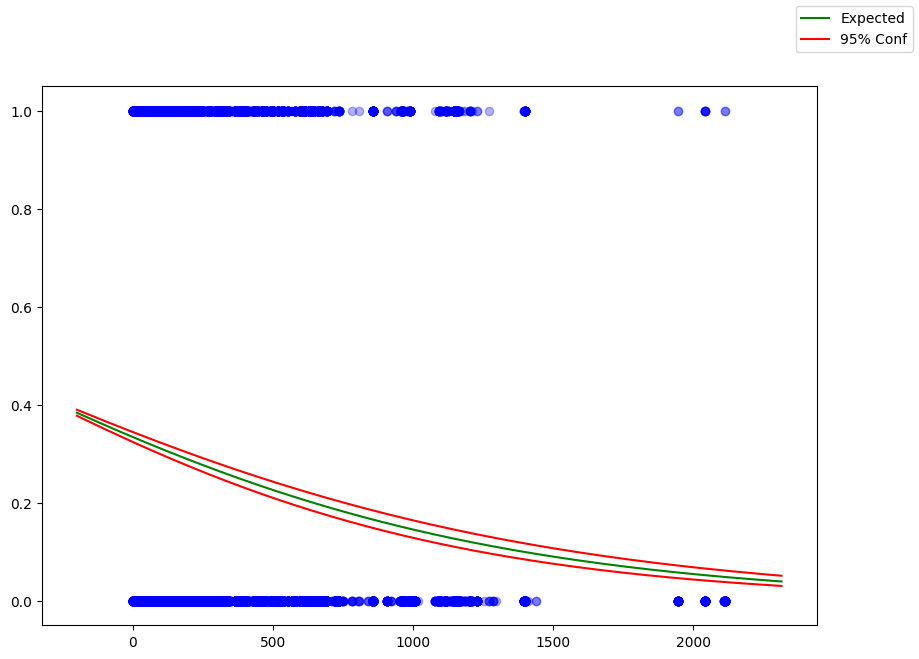

In [19]:
def ex_7c_plot(data: np.ndarray, _regression_result: Tuple[np.ndarray, np.ndarray]):

    x_data = data[:, 0]
    y_data = data[:, 1]
    x_line = np.linspace(x_data.min() - 200, x_data.max()+200, 200)
    coefficients, coefficients95 = _regression_result

    # Plot fitted line
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.plot(x_line, fossil_utils.sigmoid(x_line, coefficients[0], coefficients[1]), color="green")

    # Plot 95% confidence lines. NOTE: Confidence coefficient are column vectors
    lower, upper = np.hsplit(coefficients95, indices_or_sections=2)
    ax.plot(x_line, fossil_utils.sigmoid(x_line, upper[0], upper[1]), color="red")
    ax.plot(x_line, fossil_utils.sigmoid(x_line, lower[0], lower[1]), color="red")

    ax.scatter(x_data, y_data, color="blue", alpha=0.3)
    fig.legend(("Expected","95% Conf"))

ex_7c_plot(regression_data, regression_result)

## 1.6 Statistical Significance

In [20]:
def ex_8(eu_localities: pd.DataFrame, coefficients: np.ndarray) -> pd.Series:
    c0, c1 = coefficients[0], coefficients[1]

    # Calculate expected ratio of first occurrences given the sampling of previous time unit
    expected_ratio = fossil_utils.sigmoid(eu_localities["AREA_TOTAL_OCC_PREV_TU"].to_numpy(), c0, c1)
    return pd.Series(expected_ratio)

europe_full_data["EXPECTED_RATIO_FIRST_OCC"] = ex_8(europe_full_data, regression_result[0])

#### Notes on Exercise 9
The exercise asks to calculate the probability of observing as many or more first occurrences in the focal area than what is actually found, using the library **scipy.stats.binom**.
To accomplish this, we can use the Complementary Cumulative Distribution, defined as $1 - P(X \leq k)$. 
The documentation suggests to use the Survival Function `.sf(k, n, p)`, which calculates exactly what we need (`1 - cdf`) and it's even more precise at times.

In [21]:
def ex_9(europe_full_data: pd.DataFrame) -> pd.Series:
    significances = []
    # Iterate through each occurrence, 
    for _, row in europe_full_data.iterrows():
        n = row["AREA_TOTAL_OCC"]
        p = row["EXPECTED_RATIO_FIRST_OCC"]
        k = row["AREA_FIRST_OCC"]

        # Calculate the significance using the complementary cumulative distribution function (Survival Function)
        # Check https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html#scipy.stats.binom
        observation_significance = scipy.stats.binom.sf(k, n, p)
        significances.append(observation_significance)

    return pd.Series(significances, index=europe_full_data.index)

europe_full_data["SIGNIFICANCE"] = ex_9(europe_full_data)

#### Notes on Ex.10
It is slow! It has to render 17 maps with multiple marker types in it, be patient. For me it takes around 50 seconds. 

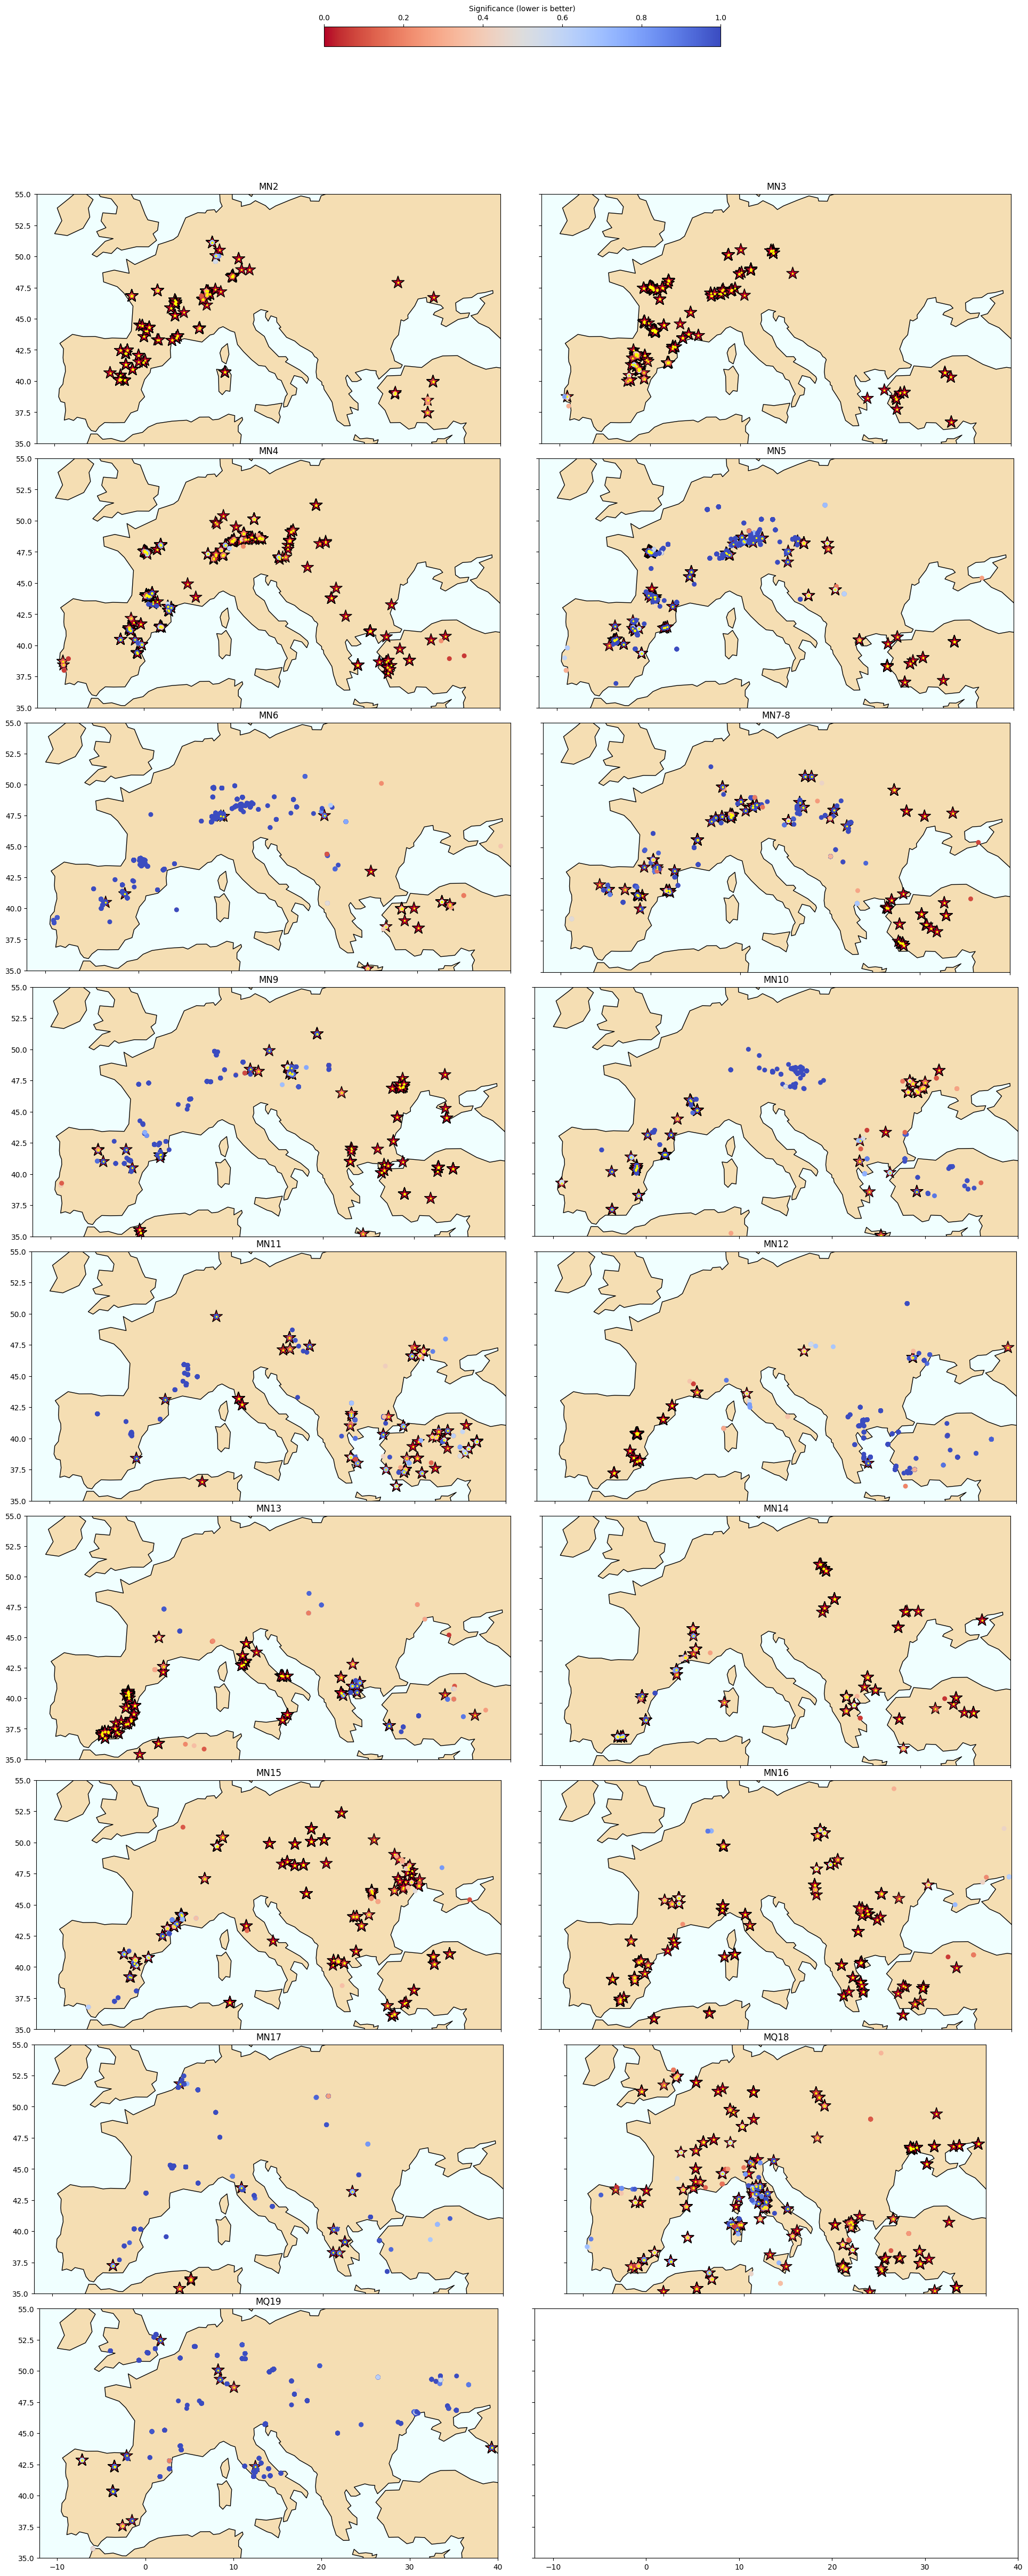

In [22]:
def ex_10_plot(europe_full_data: gpd.GeoDataFrame):

    groups = europe_full_data.groupby(TIME_UNIT)

    # Create subplots and change ax to 1d Array
    n_cols = 2
    n_rows = math.ceil(len(groups) / n_cols)
    fig, ax = plt.subplots(n_rows, n_cols, sharex="all", sharey="all", figsize=(12*n_cols, 8*n_rows))
    ax = ax.reshape((ax.size,))

    # Colorbar styles
    cmap = plt.colormaps['coolwarm'].reversed()
    norm = mpl.colors.Normalize(vmin=0, vmax=1)

    i = 0
    for tu_index, group in groups[["geometry", "SIGNIFICANCE"]]:
        # Print world map (restricted to Europe) and style it
        ax[i].set_ylim((35,55))
        ax[i].set_xlim((-12,40))
        ax[i].set_facecolor("azure")
        ax[i].set_title(fossil_utils.tu_index_to_name(tu_index))
        world_map.plot(ax=ax[i], color="wheat", edgecolor="black")

        significant = group["SIGNIFICANCE"] < 0.05
        
        # Background: Plot big, red stars for significant occurrences
        group[significant].plot(ax=ax[i], column="SIGNIFICANCE", cmap=cmap, norm=norm, edgecolor="black", marker="*", markersize=300)

        # Mid-ground: plot less significant occurrences, so they are not hidden from the big stars
        group[~significant].plot(ax=ax[i], column="SIGNIFICANCE", cmap=cmap, norm=norm, markersize=30)

        # Foreground: Highlight significant points with a small yellow dot, so they are visible even when
        # many less significant occirrences hide the significant markers
        group[significant].plot(ax=ax[i], marker=".", color="yellow", markersize=10)

        # Advance Axes
        i += 1


    fig.subplots_adjust(wspace=0.05, hspace=0.06)
    fig.colorbar(ax=ax, label="Significance (lower is better)", mappable=cm.ScalarMappable(cmap=cmap, norm=norm), shrink=0.4, location="top", orientation='horizontal')

    plt.show()

ex_10_plot(fossil_utils.to_GeoDataFrame(europe_full_data))

In the older time units (MN2 and MN3) there is a high number of new fossil occurrences in Western Europe, on a region that covers Spain, France and Switzerland. New species appear on MN4 and MN5 covering an arc that goes from Spain all the way down the Balkan peninsula to Turkey. Starting from MN7-8, new species appear over East Europe and the trends continue until MN12, where most of new occurrences happen along the Spanish and French mediterranean coast. MN13 new specitations happen prevalentry in Southern Europe, but only to spread all over Europe in the following time units. In MQ18 there is an exceptionally high rate of new species appearing all over europe, with highest concentration in Italy. Time units MN17 and MQ19 don't seem to show signs of high specitation.